이 코드는 민유진님에게 권리가 있습니다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Embedding, Conv1D, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import gensim
from gensim.models import word2vec
from konlpy.tag import Kkma, Komoran, Okt, Hannanum 

import re

# 데이터 준비하기

In [391]:
# TSV 파일 불러오기
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('dev.tsv', sep='\t')

In [392]:
train.head()

,comments,contain_gender_bias,bias,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate


In [390]:
train.isna().sum(), test.isna().sum()

(comments         0
 hate             0
 label_encoded    0
 dtype: int64,
 comments         0
 hate             0
 label_encoded    0
 dtype: int64)

In [4]:
# 라벨 데이터 확인 - 다중 분류 문제
train['hate'].value_counts()/len(train)

hate
none         0.441489
offensive    0.316489
hate         0.242021
Name: count, dtype: float64

In [6]:
# train 과 test 라벨 데이터 분포 비교 (비슷함 확인)
test['hate'].value_counts()/len(test)

hate
offensive    0.401274
none         0.339703
hate         0.259023
Name: count, dtype: float64

In [7]:
train.shape, test.shape

((7896, 4), (471, 4))

In [260]:
train = train[['comments','hate']]
test = test[['comments','hate']]

# 타겟변수 인코딩 (라벨-원핫 인코딩)

In [261]:
# LabelEncoder를 사용하여 문자열 레이블을 정수로 변환
label_encoder = LabelEncoder()
train['label_encoded'] = label_encoder.fit_transform(train['hate'])

# # OneHotEncoder를 사용하여 원-핫 인코딩 : loss : sparse 삭제 
# onehot_encoder = OneHotEncoder(sparse=False)
# onehot_encoded = onehot_encoder.fit_transform(train[['label_encoded']])

# train_label = utils.to_categorical(train_label) # 0 or 1 -> one-hot vector
# test_label = utils.to_categorical(test_label) # 0 or 1 -> one-hot vector

# # 결과 확인
# # train['label_encoded'] = train['label_encoded'].astype(str)  # 정수를 문자열로 변환 (선택적)
# train['onehot_encoded'] = list(map(lambda x: list(map(int, x)), onehot_encoded))
print(train)

                                               comments  hate  label_encoded
0     (현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...  hate              0
1     ....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...  none              1
2     ...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...  hate              0
3                    1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데  none              1
4     1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...  hate              0
...                                                 ...   ...            ...
7891                                      힘내세요~ 응원합니다!!  none              1
7892                             힘내세요~~삼가 고인의 명복을 빕니다..  none              1
7893                              힘내세용 ^^ 항상 응원합니닷 ^^ !  none              1
7894  힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...  none              1
7895                                 힘들면 관뒀어야지 그게 현명한거다  none              1

[7896 rows x 3 columns]


# 한국어 전처리

In [85]:
def morphs_cleaning(column):
    '''
    1. 함수 설명 : input으로 넣은 열을 토큰화하고 불용어 제거, 숫자 및 구두점 제거 문자만 추출, 클렌징 작업을 마친 문장을 리스트로 반환하는 함수
    2. Args : 
        column   (Series) : 클렌징하고 싶은 열 이름
    3. Return : 
        cleaned_list (List) : 클렌징 작업을 마친 리스트 형태의 데이터
    '''

    okt = Okt()
    
    cleaned_list = [] # 클렌징된 본문 내용
    # 감정분석이므로 중립적인 단어만 빼자
    stopwords = ['하다','있다','같다','너무','되다','그렇다','돼다','나다','때문','스럽다','지금','우리','되어다','이렇다'
                 ,'하나','이다','대해','위해','자기','그렇게','수가','두다','진짜','정도','이렇게','내다','이지','말다'
                 ,'내','들','것','나','수','게','거','다','때','이','적','그','응','난','걸','건','곳','후','님','데','중','만'
                 , '좀', '한', '니', '하', '더', '뭐', '애', '저', '지다', '하', '너', '해', '네', '기', '아', '도', '전','알'
                 , '자', '대', '함', '듯', '두', '줄','임','살','분','남','지','머','원','보다','대다','제','연','성','문','앞'
                 , '가','은','에','는','을','의','를','로','으로','고','에서','하고','들다','가다','인데','주','구','번'
                 ,'인','라','면','랑','까지','야','한테','냐','요','이나','차다','이나','치','리다','과','서','부터'
                 ,'해주다','싶다','이랑','이네','처럼','와','여','비','라고','이라','에게','이냐','해보다','이야','이고','이라고'
                 ,'인가','이다','녀','명','눈','세','서다','사','찌','시','위','상','기','니까','엔','에는','그','저','처','조'
                 ,'래','라는','모','물','보','식','든','단','에도','이번','이기','젠','몇','질','이라는','바','재','감','얼','양'
                 ,'작','백','죠','이니','솔','인거','밖에','지만','어','라면','이래','그거','저거','이거','씩','박'
                ]
    for idx in range(len(column)):
        #- 토큰화, 품사 태깅
        # stem은 아름다운-> 아름답다
        # norm ~하게 -> 하다
        raw_morphs_tagged = okt.morphs(column[idx], norm=True, stem=True)

        # 불용어 제거
        word_cleaned = []
        for word in raw_morphs_tagged: #  ('서울', 'Noun'), ('인천', 'Noun')
            # Foreign == ”, “ 와 같이 제외되어야할 항목들 
            # & 한 글자로 이뤄진 단어들을 제외 & 원치 않는 단어들을 제외
            # 특수 기호에 해당하지 않을 경우

            if (word not in stopwords) and re.match('^[a-zA-Z가-힣]+', word): 
                word_cleaned.append(word) 

        word_cleaned = ' '.join(word_cleaned)
        cleaned_list.append(word_cleaned)


    return cleaned_list


In [86]:
# 전처리된 열과 사용빈도를 확인하기
cleaned_list = morphs_cleaning(train['comments'])

In [395]:
print(train['comments'][:3])

0    (현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...
1    ....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...
2    ...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...
Name: comments, dtype: object


In [394]:
cleaned_list[:3]

['현재 호텔 주인 심정 마른하늘 날벼락 맞다 호텔 망하다 생기다 누 군 계속 추모 받다',
 '한국 미인 대표 너무나 곱 아름답다 모습 모습 뒤 슬픔 미처 알다',
 '못 넘다 고통 즐기다 넘다 마땅하다 처벌 받다 래야 공정하다 사회 심다 거두다']

In [88]:
# 전처리한 결과를 텍스트 파일로 저장
result_file = 'korean_hate_speech.txt'       # 텍스트 파일임!
with open(result_file, 'wt', encoding='utf-8') as myfile:
     myfile.write('\n'.join(cleaned_list))           # 라인으로 결합

print(result_file + ' 파일 저장됨!')

korean_hate_speech.txt 파일 저장됨!


# 토큰화 및 사전 만들기

In [348]:
padded_sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       1181, 1304, 2565, 1877, 5965, 4171,   40, 1304,  160,  792,  697,
        149, 1878,   30], dtype=int32)

# Word2Vec 임베딩하기

In [93]:
# 지난 번에 만든 word2vec 모델 불러오기
model_filename = '/Users/youjin/Desktop/구름 자연어처리/과제/3차 과제/word2vec.model'
model = word2vec.Word2Vec.load(model_filename)

In [94]:
def make_embedding(vocab_size, embedding_dim):

    embeddings_dict = {}
    for i in range(len(word_index)):
        if i < max_vocab_size:
            word = list(word_index.keys())[i] 
            try:
                embeddings_dict[word] = model.wv[word]
            except KeyError:
                pass

    embedding_matrix = np.zeros((vocab_size, embedding_dim))    # zero 로 초기화   
    
    print("word 갯수 =", vocab_size)
    print(embedding_matrix.shape)
    
    count = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:         # 해당 word 가 없으면 all zero 로 남겨둠
            count += 1
            embedding_matrix[i] = embedding_vector
    print('pre-trained embedding : {} 개'.format(count))
    return embedding_matrix

In [95]:
# create embedding layer
embedding_dim=100
embedding_matrix = make_embedding(vocab_size, embedding_dim)

word 갯수 = 11730
(11730, 100)
pre-trained embedding : 6180 개


# 모델 만들기

In [310]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred, multi_class='ovo') # 'ovr' 또는 'ovo'
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))


In [366]:
filter_sizes = [1,2,3,5]
num_filters = 32

def get_model():    
    """
    
    
    """
    inp = Input(shape=(max_len, ))
    x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True)(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Reshape((max_len, embedding_dim, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(max_len - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(max_len - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(max_len - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(max_len - filter_sizes[3] + 1, 1))(conv_3)
        
    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = Dropout(0.1)(z)
        
    outp = Dense(3, activation="softmax")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [373]:
model = get_model()

batch_size = 256
epochs = 7

X_tra, X_val, y_tra, y_val = train_test_split(padded_sequences, train['label_encoded'], train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

In [374]:
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=2)


Epoch 1/7

 ROC-AUC - epoch: 1 - score: 0.656588 

30/30 - 1s - loss: 1.0573 - accuracy: 0.4465 - val_loss: 1.0123 - val_accuracy: 0.4835 - 1s/epoch - 41ms/step
Epoch 2/7

 ROC-AUC - epoch: 2 - score: 0.673696 

30/30 - 1s - loss: 0.9833 - accuracy: 0.4966 - val_loss: 0.9827 - val_accuracy: 0.5013 - 669ms/epoch - 22ms/step
Epoch 3/7

 ROC-AUC - epoch: 3 - score: 0.692444 

30/30 - 1s - loss: 0.9398 - accuracy: 0.5387 - val_loss: 0.9505 - val_accuracy: 0.5038 - 979ms/epoch - 33ms/step
Epoch 4/7

 ROC-AUC - epoch: 4 - score: 0.709756 

30/30 - 1s - loss: 0.8995 - accuracy: 0.5658 - val_loss: 0.9280 - val_accuracy: 0.5367 - 971ms/epoch - 32ms/step
Epoch 5/7

 ROC-AUC - epoch: 5 - score: 0.724771 

30/30 - 1s - loss: 0.8521 - accuracy: 0.6014 - val_loss: 0.9091 - val_accuracy: 0.5443 - 969ms/epoch - 32ms/step
Epoch 6/7

 ROC-AUC - epoch: 6 - score: 0.738272 

30/30 - 1s - loss: 0.8026 - accuracy: 0.6383 - val_loss: 0.8845 - val_accuracy: 0.5468 - 710ms/epoch - 24ms/step
Epoch 7/7

 ROC-AUC

In [369]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

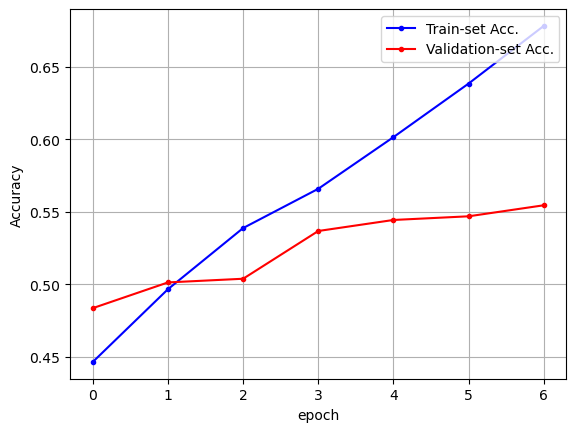

In [375]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

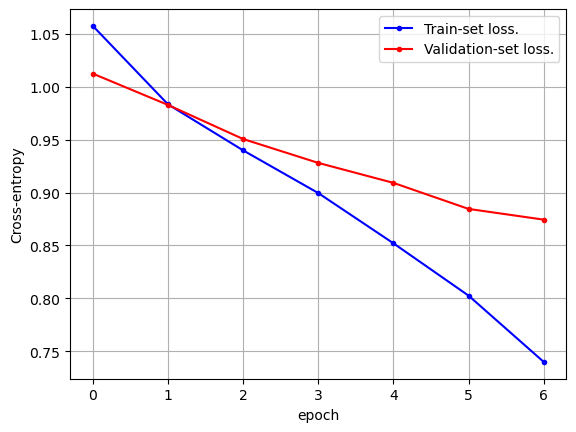

In [376]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

# 테스트 데이터 평가하기

In [324]:
test['label_encoded'] = label_encoder.transform(test['hate'])

In [325]:
# 전처리된 열과 사용빈도를 확인하기
test_cleaned_list = morphs_cleaning(test['comments'])

In [326]:
test_cleaned_list

['송중기 시대극 믿다 첫 회 신선하다 좋다',
 '지현우 나쁘다 놈',
 '알바 쓰다 많이 돈 욕심 없다 골목 식당 왜 나오다 겨 댕기 나하 산 에가 팔다',
 '설마 현정 작가 아니다',
 '이미자 씨 송혜교 씨 돈 그리다 많다 탈세 말고 돈 평소 불우 이웃 기부 사시',
 '일베충 거리',
 '아이즈 힘내다 일본 진출 일본 좋다 모습 보여주다 팬 응원',
 '강부자 선생님 전미선 비보 오열 눈물 힘내다',
 '알다 그만',
 '이영자 씨 진정 녹화 불참 끝내다 자진하차 시청자 고려 안 일방 불참 아니다 엠비씨 시청율 좋다 고민 결방 아니다 폐지',
 '이경규 세련되다 나이 차 은우 누가 알꼬 아무리 잘생기다 다해 배우다 야하다 점 많다 신분',
 'c 발 어쩌라고 뭔 기사 계속 나오다',
 '멋지다',
 '명수 응근슬쩍 뒷 치기 각 잡',
 '철구 별 풍 쏘다 놈 수준 똑같다',
 '둘 화장실 싸우다',
 '송이 매니저 거지 치과 치료 비용 타다 솔직하다 치아 관리 얼마나 안 앞니 시커멓다 따다 치과 공포증 핑계 볼때 마다 얼마나 거슬리다 쟤 부모님 앞니 치료 못',
 '언제 반일 감정 불타다 막상 역사 모르다 개돼지 꼭 흥분하다',
 '기자 왜 아니다 일기장 써다 제목 오',
 '아직도',
 '조우종 장성규 보단 낫 장성규 얼마 못 간다',
 '주말 드라마 장사 엄마 폐암 걸리다 드라마',
 '남자 쪽 여자 버리다 알다 자세하다 여자 쪽 집 남자 버리다 버리다 이제',
 '언플 오지 언플 연기력 겸손하다 치다 배우다',
 '한화 이글스 해산 빱',
 '유이 자연스럽다 연기',
 '알다 이제 조용하다 관 종이',
 '죽창 울다 반 일 선동 뒤 일제 쓸다 쓰다 한국 정치인 간악 쪽 XX 울다 즈그 렉서스 끌 일제 전자기기 쓰다 북한 놈 순진하다 부화 뇌동 국민 바보',
 '서현진 이민기 연기 식상하다',
 '임신 몸 안좋다 임신 안되다 알다 우울하다 왜 따다 따르다 임신 잘 안되다',
 '왜 유재석 에게는 얼굴 케익 폭탄 벌칙 안',
 '유승준 천재 재능 

In [327]:
test_input_sequences = tokenizer.texts_to_sequences(test_cleaned_list)

# 패딩을 사용하여 시퀀스의 길이를 맞춤
test_padded_sequences = pad_sequences(test_input_sequences, maxlen=max_len, padding='post')

In [398]:
test_padded_sequences.shape

(471, 36)

In [377]:
result = model.evaluate(test_padded_sequences, test['label_encoded'])
print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

15/15 [==============================] - 0s 2ms/step - loss: 0.8817 - accuracy: 0.5817
loss (cross-entropy) : 0.8816719651222229
test accuracy : 0.5817409753799438


In [ ]:
임베딩 , 데이터의 처리가 중요
데이터 정보 압축
데이터 EDA로 좀 더 태스크에 맞게 하기?

# 정확도 계산하는 다른 방법

In [378]:
y_pred = model.predict(test_padded_sequences, batch_size=1024)
test_pred_argmax = y_pred.argmax(axis=-1)
accuracy = accuracy_score(test_pred_argmax, test['label_encoded'])
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 0s 23ms/step
Accuracy: 0.5817409766454352


# 디코딩하여 정답 데이터 저장

In [389]:
y_pred = model.predict(test_padded_sequences, batch_size=1024)
test_pred_argmax = y_pred.argmax(axis=-1)
decoded_predicted_labels = label_encoder.inverse_transform(test_pred_argmax)
pd.DataFrame({'Predicted_hate':decoded_predicted_labels}).to_csv('submission.csv', index=False)

1/1 [==============================] - 0s 24ms/step
